In [1]:
# Load modules necessary
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from scipy.signal import detrend

# %matplotlib qt
%matplotlib ipympl

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load sample dataset

##### For EEG dataset, we will use CHB-MIT Scalp EEG Dataset from here: https://physionet.org/content/chbmit/1.0.0/chb01/#files-panel

##### The original dataset contains 22 subjects. However, here in this tutorial we will explore data from Subject 01
##### You can download the dataset from Brightspace

# Matrix multiplications as filters

In [2]:
# Path to the EEG file
eegPath = '../../Datasets/EEG/sub-01/eeg/sub-01_task-daf_eeg_filtered.vhdr'

# Load the EEG file using MNE
# MNE has different read formats for different EEG file types
# Here we are using read_raw_edf to read the EEG file
# preload=True loads the data into memory (default is False, which loads the data when needed)
raw = mne.io.read_raw_brainvision(eegPath, preload=True)
elecPos = pd.read_csv('../../Datasets/EEG/sub-01/eeg/sub-01_electrodes.tsv', sep='\t')
# Add fiducials
fiducials = pd.DataFrame({
    'name': ['Nz', 'LPA', 'RPA'],
    'x': [-4.129838157917329e-18, -0.0729282673627754, 0.08278152042487033],
    'y': [0.10011015398430487, 3.008505424862354e-18, -3.414981080487009e-18],
    'z': [-5.7777898331617076e-33, 3.851859888774472e-34, 3.4666738998970245e-33]
})

# Concatenate the original electrode positions with the fiducials
elecPos = pd.concat([elecPos, fiducials], ignore_index=True)

montage = mne.channels.make_dig_montage(
    ch_pos=dict(zip(elecPos['name'], elecPos[['x', 'y', 'z']].values)),
    coord_frame='head'
)
raw.set_montage(montage)

data = raw.get_data()
n_channels = data.shape[0]
n_samples = data.shape[1]

Extracting parameters from ../../Datasets/EEG/sub-01/eeg/sub-01_task-daf_eeg_filtered.vhdr...
Setting channel info structure...
Reading 0 ... 244237  =      0.000 ...   976.948 secs...


In [3]:
# Select an electrode via vector multiplication
selectElecIdx = 2
selectElecVec = np.zeros((n_channels,1))
selectElecVec[selectElecIdx] = 1
print(selectElecVec.shape)
print(data.shape)
selectElecData = (selectElecVec.T @ data)

# print(selectElecVec)
print(selectElecData.shape)
print(selectElecData)

(66, 1)
(66, 244238)
(1, 244238)
[[ 4.08251469e-07 -7.93320688e-07 -6.54134187e-07 ... -1.90185424e-04
   1.70218016e-04 -1.82408512e-04]]


In [ ]:
# Select a subset of electrodes via matrix multiplication
# Let's select channels 1, 3, and 5
selected_channels = [0, 2, 4] # Note that Python is 0-indexed
ChannelMultiplier = np.zeros((len(selected_channels), n_channels))
for i, chan in enumerate(selected_channels):
    ChannelMultiplier[i, chan] = 1
print(ChannelMultiplier.shape)

print(data.shape)
data_selected = (ChannelMultiplier @ data)

plt.figure()
plt.imshow(ChannelMultiplier, aspect='auto')
plt.show()

(6, 66)
(66, 244238)
(6, 244238)


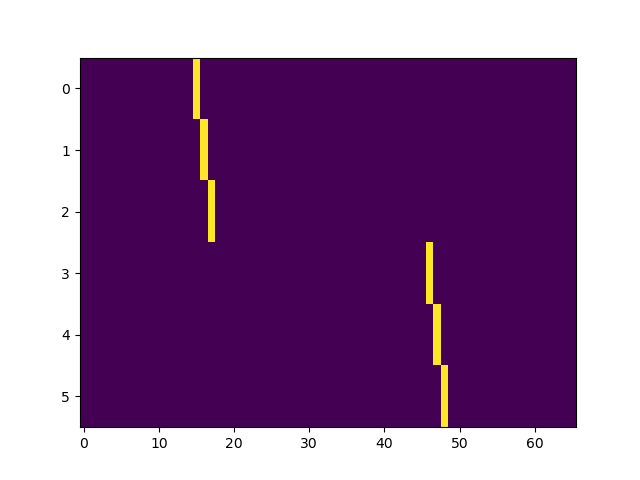

In [5]:
# Average an electrode-ROI via vector multiplication
# Let's average across occipital electrodes
elecList = ['O1', 'Oz', 'O2', 'PO3', 'POz', 'PO4']
# Get indices for the specified electrodes
elecIdx = [elecPos[elecPos['name'] == elec].index[0] for elec in elecList]
elecVec = np.zeros((len(elecIdx), n_channels))
for i, elec in enumerate(elecIdx):
    elecVec[i, elec] = 1/len(elecIdx)
elecData = (elecVec @ data)

# print(elecVec)
print(elecVec.shape)
print(data.shape)
print(elecData.shape)

plt.figure()
plt.imshow(elecVec, aspect='auto')
plt.show()


(66, 66)
(66, 244238)


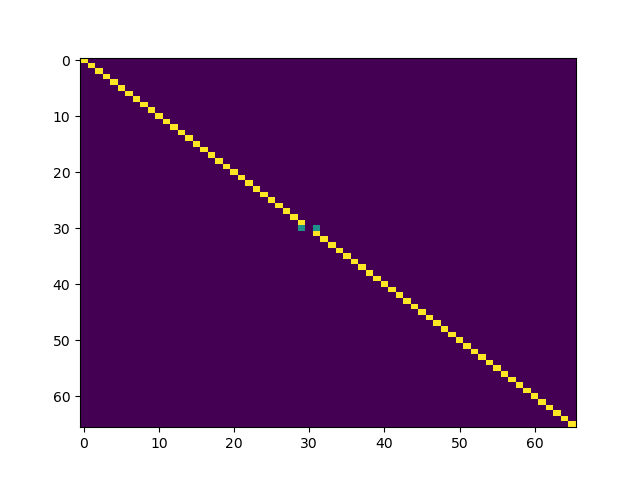

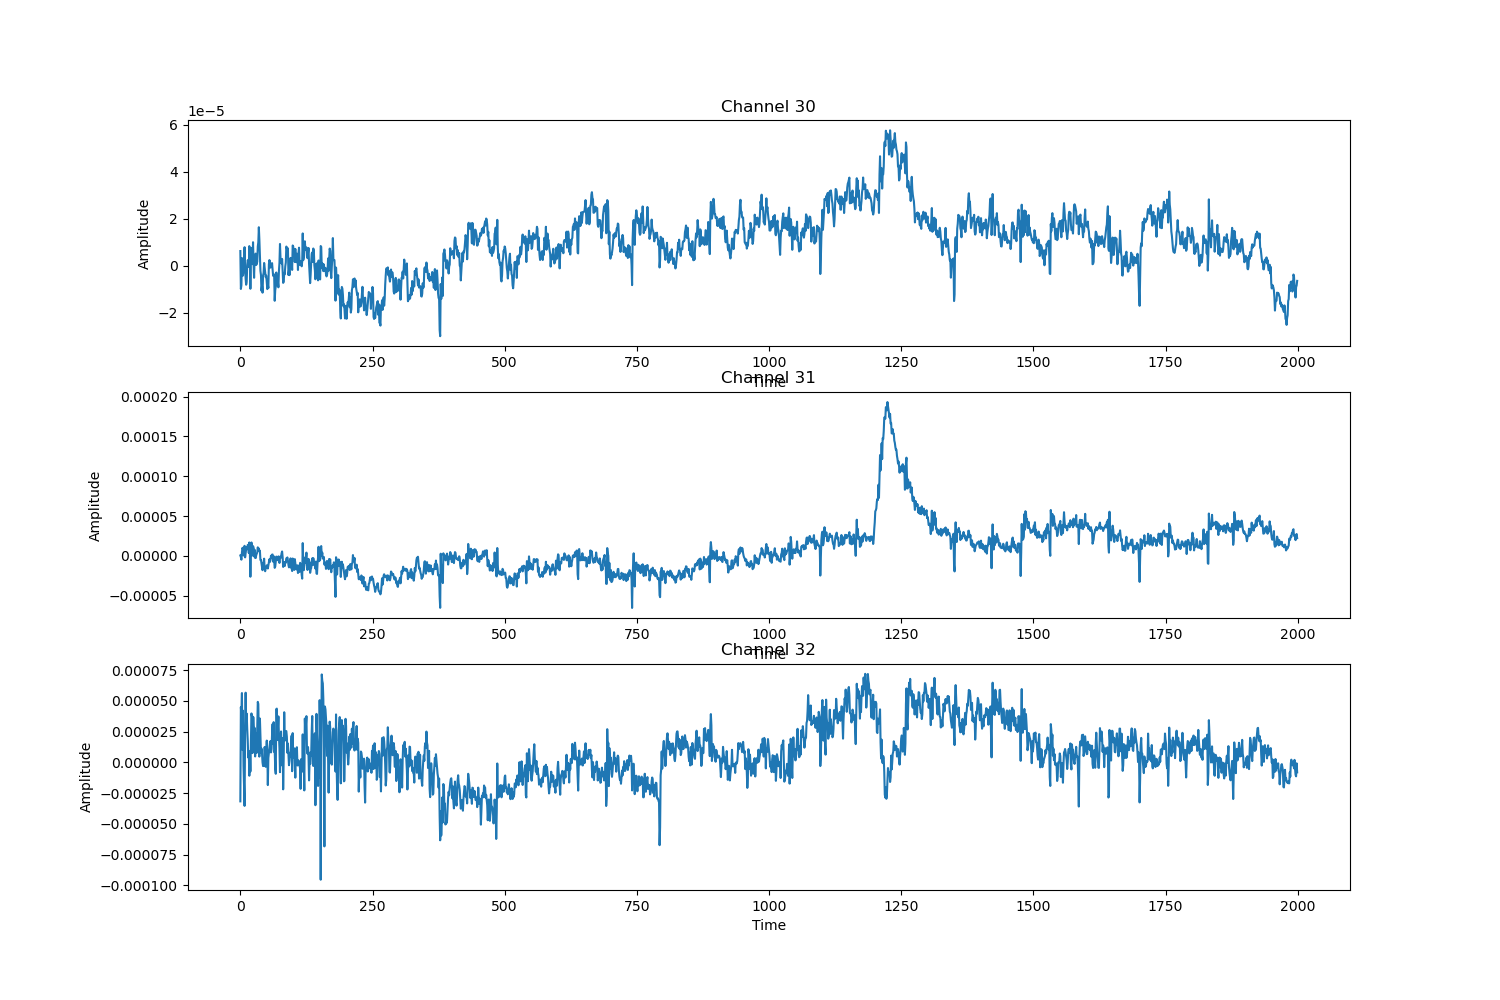

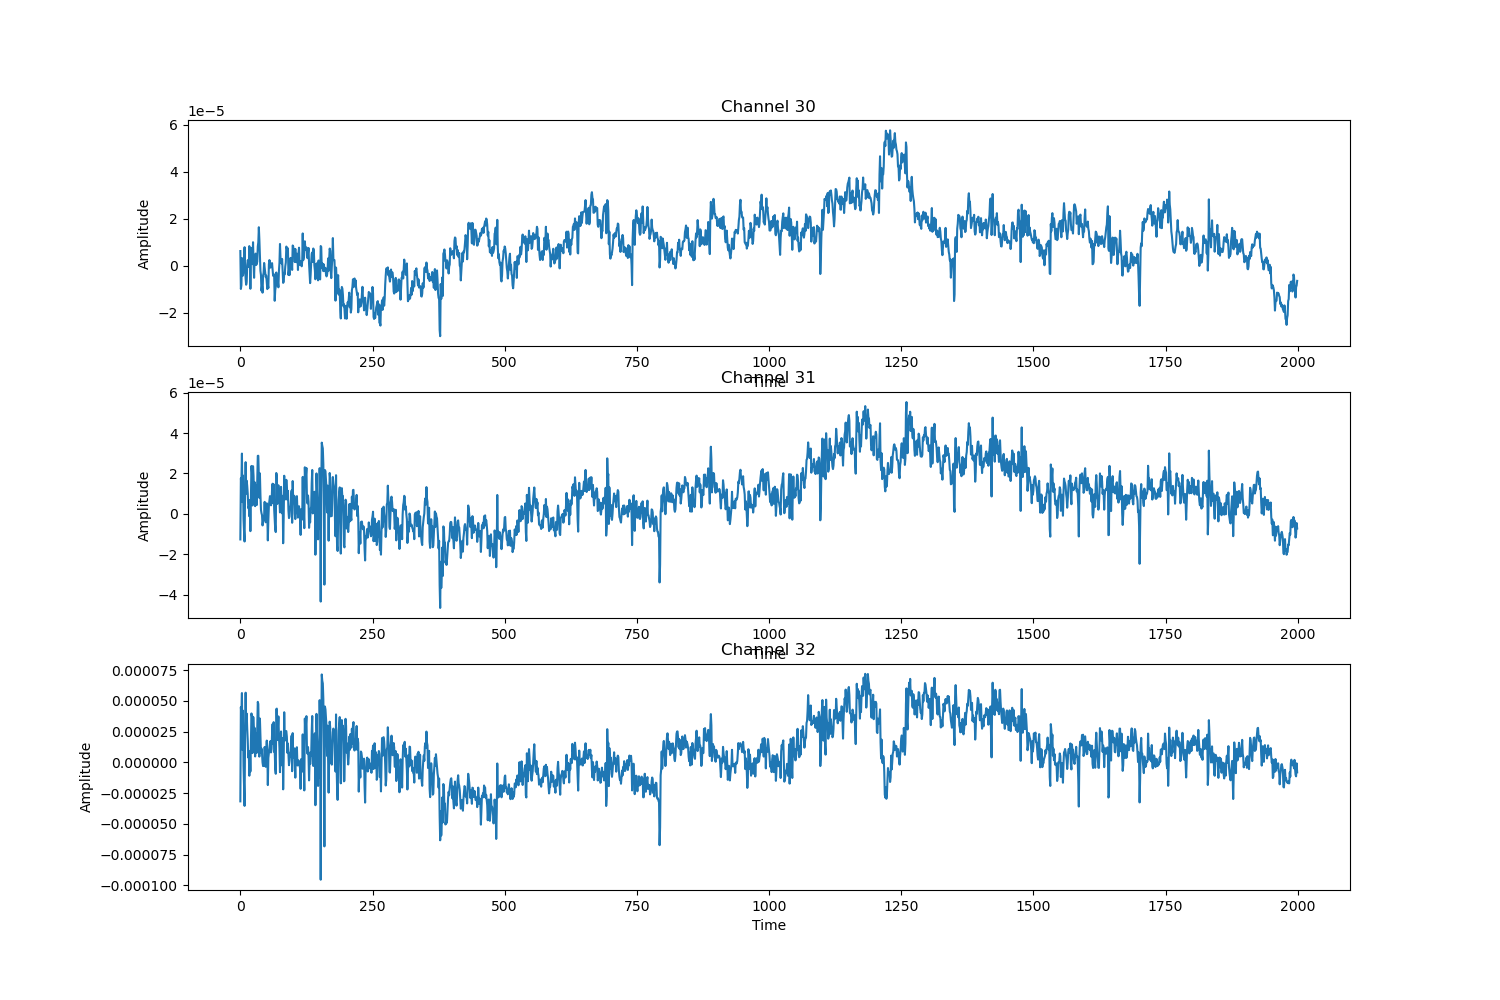

In [6]:
# Channel interpolation via matrix multiplication
# Let's interpolate channel 31 using channels 30 and 32
interp_channel = 30
InterpMultiplier = np.eye(n_channels)
InterpMultiplier[interp_channel, interp_channel-1] = 1/2
InterpMultiplier[interp_channel, interp_channel+1] = 1/2
InterpMultiplier[interp_channel, interp_channel] = 0
print(InterpMultiplier.shape)
print(data.shape)
data_interp = (InterpMultiplier @ data)

plt.figure()
plt.imshow(InterpMultiplier, aspect='auto')
plt.show()

# Plot the interpolated EEG data

f, axs = plt.subplots(3, 1, figsize=(15, 10))
axs = axs.flatten()
for i, chan in enumerate(np.array([29, 30, 31])):
    ax = axs.flatten()[i]
    ax.plot(data[chan, :2000])
    ax.set_title(f"Channel {chan+1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
plt.show()

f, axs = plt.subplots(3, 1, figsize=(15, 10))
axs = axs.flatten()
for i, chan in enumerate(np.array([29, 30, 31])):
    ax = axs.flatten()[i]
    ax.plot(data_interp[chan, :2000])
    ax.set_title(f"Channel {chan+1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
plt.show()


[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


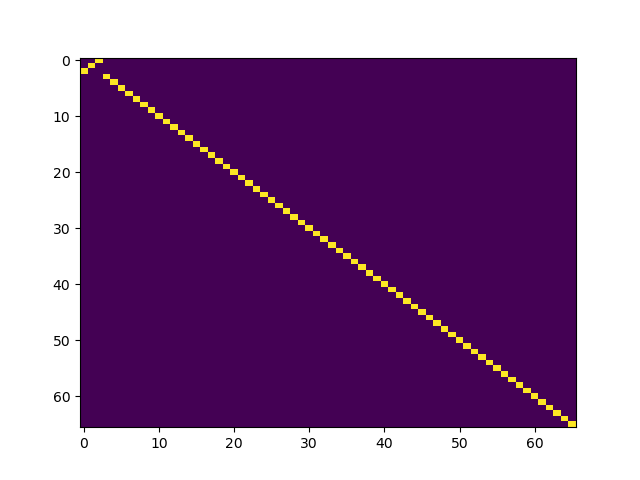

In [7]:
# Fixing swapped electrodes
# Channel 1 and 3 have been plugged into wrong position in the cap
# Swap the channels using matrix multiplication
SwapMultiplier = np.eye(n_channels)
SwapMultiplier[0, 2] = 1
SwapMultiplier[2, 0] = 1
SwapMultiplier[0, 0] = 0
SwapMultiplier[2, 2] = 0

data_swapped = (SwapMultiplier @ data)

print(SwapMultiplier)

plt.figure()
plt.imshow(SwapMultiplier, aspect='auto')
plt.show()

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


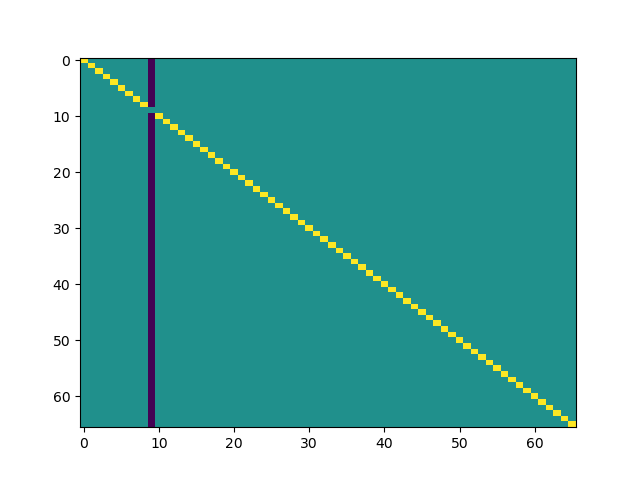

In [8]:
# Re-referencing data to a single channel using matrix multiplication
# Let's use channel 10 as the reference channel

ref_channel = 9
ReferenceMultiplier = np.eye(n_channels)
ReferenceMultiplier[:, ref_channel] = -1
ReferenceMultiplier[ref_channel, :] = 0
print(ReferenceMultiplier)
data_single_ref = (ReferenceMultiplier @ data)

plt.figure()
plt.imshow(ReferenceMultiplier, aspect='auto')
plt.show()


[[ 0.98484848 -0.01515152 -0.01515152 ... -0.01515152 -0.01515152
  -0.01515152]
 [-0.01515152  0.98484848 -0.01515152 ... -0.01515152 -0.01515152
  -0.01515152]
 [-0.01515152 -0.01515152  0.98484848 ... -0.01515152 -0.01515152
  -0.01515152]
 ...
 [-0.01515152 -0.01515152 -0.01515152 ...  0.98484848 -0.01515152
  -0.01515152]
 [-0.01515152 -0.01515152 -0.01515152 ... -0.01515152  0.98484848
  -0.01515152]
 [-0.01515152 -0.01515152 -0.01515152 ... -0.01515152 -0.01515152
   0.98484848]]


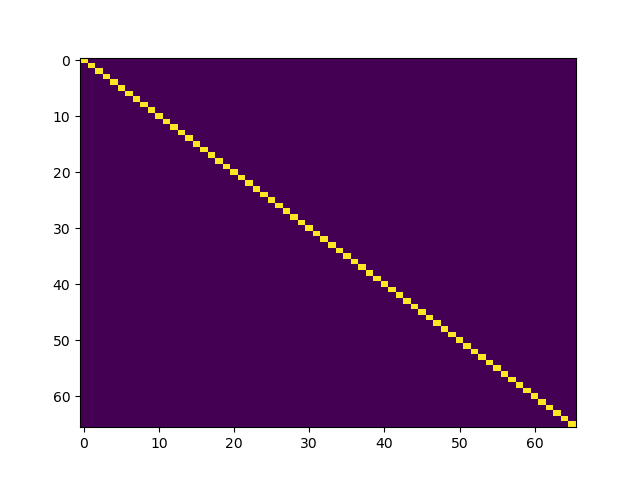

In [9]:
# Average Re-referencing via matrix multiplication
averages_mat = np.ones(n_channels)/n_channels 

data_re_ref = (np.eye(n_channels)@data) - (averages_mat @ data)
# Matrix multiplication is distributive
# and hence we can do referencing as: 
# A * X - B * X
# OR
# (A - B) * X
data_re_ref = (np.eye(n_channels)- averages_mat)@data  


MeanMultiplier = np.eye(n_channels) - np.ones((n_channels, n_channels))/n_channels
print(MeanMultiplier)
# data_re_ref = np.dot(MeanMultiplier, data)

# # Plot the re-referenced EEG data
# f, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
# axs = axs.flatten()
# for i in range(n_channels):
#     ax = axs.flatten()[i]
#     ax.plot(data_re_ref[i, :])
#     ax.set_title(f"Channel {i+1}")
#     ax.set_xlabel("Time")
#     ax.set_ylabel("Amplitude")

plt.figure()
plt.imshow(MeanMultiplier, aspect='auto')
plt.show()

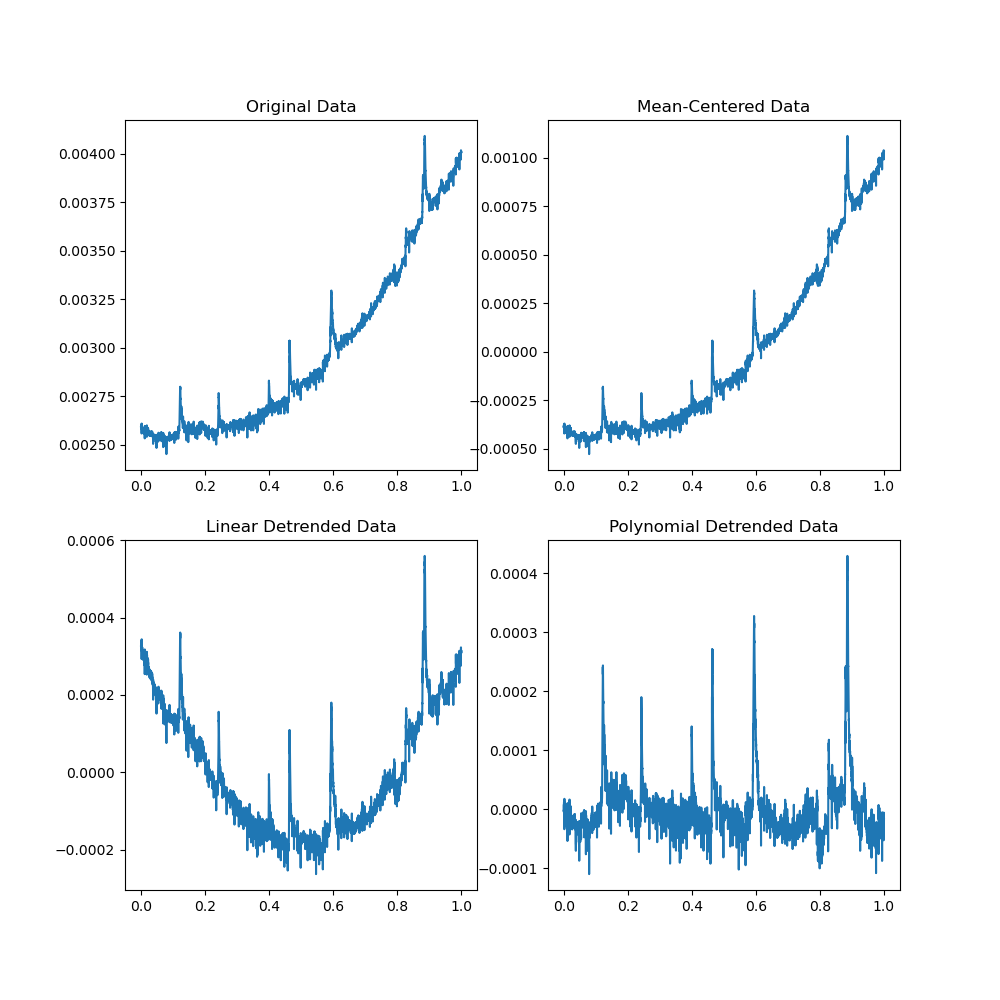

In [10]:
# Creating a fake channel with a polynomial trend
fake_data = raw.get_data()[0][:10000]
t = np.linspace(0, 1, len(fake_data))
np.random.seed(42)
trend = np.random.randn(3)
fake_data += 4e-3 * np.polyval(trend, t)

# Let us look at different ways to remove trend from the data
# First, we can simply mean-center the data
# This can be done by removing a 0th order polynomial from the data
trend0 = np.polyfit(t, fake_data, 0)
fake_data_centered = fake_data - np.polyval(trend0, t)

# Second, we can remove a linear trend from the data
# This can be done by removing a 1st order polynomial from the data
trend1 = np.polyfit(t, fake_data, 1)
fake_data_detrended = fake_data - np.polyval(trend1, t)

# Next we can remove a seond order trend from the data
# This can be done by removing a 2nd order polynomial from the data
trend2 = np.polyfit(t, fake_data, 2)
fake_data_detrended2 = fake_data - np.polyval(trend2, t)

# Plot the original data and the detrended data
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(t, fake_data)
axs[0, 0].set_title('Original Data')
axs[0, 1].plot(t, fake_data_centered)
axs[0, 1].set_title('Mean-Centered Data')
axs[1, 0].plot(t, fake_data_detrended)
axs[1, 0].set_title('Linear Detrended Data')
axs[1, 1].plot(t, fake_data_detrended2)
axs[1, 1].set_title('Polynomial Detrended Data')
plt.show()

In [20]:
# Compute power at specific frequency for a single channel by taking inner product with a complex sine wave
# Let us compute power at 10 Hz for occipital electrode O2
timeToPlot = 50 # Time in seconds to plot
t = raw.times[raw.times < timeToPlot]
N = len(t)
chName = 'O2'
elecIdx = [elecPos[elecPos['name'] == chName].index[0]][0]
x = np.arange(0,N)/N
X = data[elecIdx, raw.times < timeToPlot]

SR = raw.info['sfreq']
freqs = np.fft.fftfreq(N, 1/SR)
freqs = freqs[:N//2]
k = 10

# Create a complex sine wave at frequency k
W = np.exp(-1j * 2 * np.pi * k * N * x)

# Compute the inner product (DFT coefficient for frequency k)
# We use vector multiplication!
X_k = (W.T @ X)

power = np.real(X_k)**2 + np.imag(X_k)**2
print(f"Power at {k} Hz: {power} uV^2")

Power at 10 Hz: 0.002804427344337323 uV^2


6250
2.4996


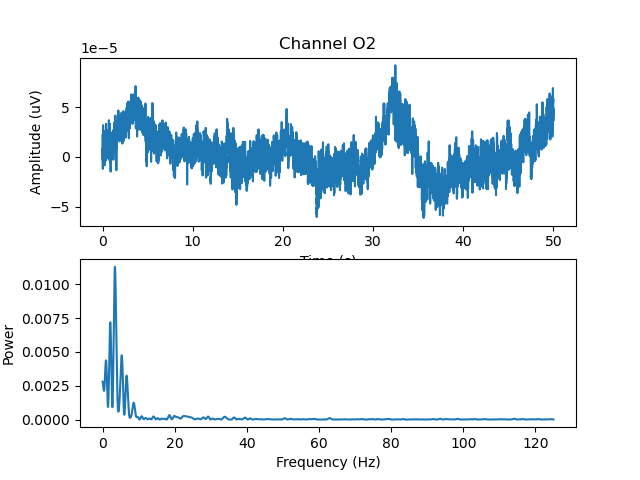

In [12]:
# Let us compute power at all frequencies for occipital electrode O2
timeToPlot = 50 # Time in seconds to plot
t = raw.times[raw.times < timeToPlot]
N = len(t)
chName = 'O2'
elecIdx = [elecPos[elecPos['name'] == chName].index[0]][0]
x = np.arange(0,N)/N
X = data[elecIdx, raw.times < timeToPlot]

SR = raw.info['sfreq']
freq_res = SR/len(X)
freqs = np.fft.fftfreq(N, 1/SR)
freqs = freqs[:N//2]
print(len(freqs))
powerVec = np.zeros(len(freqs))
for i, k in enumerate(freqs):
    W = np.exp(-1j * 2 * np.pi * k * x)

    # Compute the inner product (DFT coefficient for frequency k)
    # We use vector multiplication!
    X_k = (W.T @ X)

    powerVec[i] = np.real(X_k)**2 + np.imag(X_k)**2

freq_vector = freqs*freq_res
print(max(freq_vector))

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, X)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title(f'Channel {chName}')

plt.subplot(2, 1, 2)
plt.plot(freqs, powerVec)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.show()

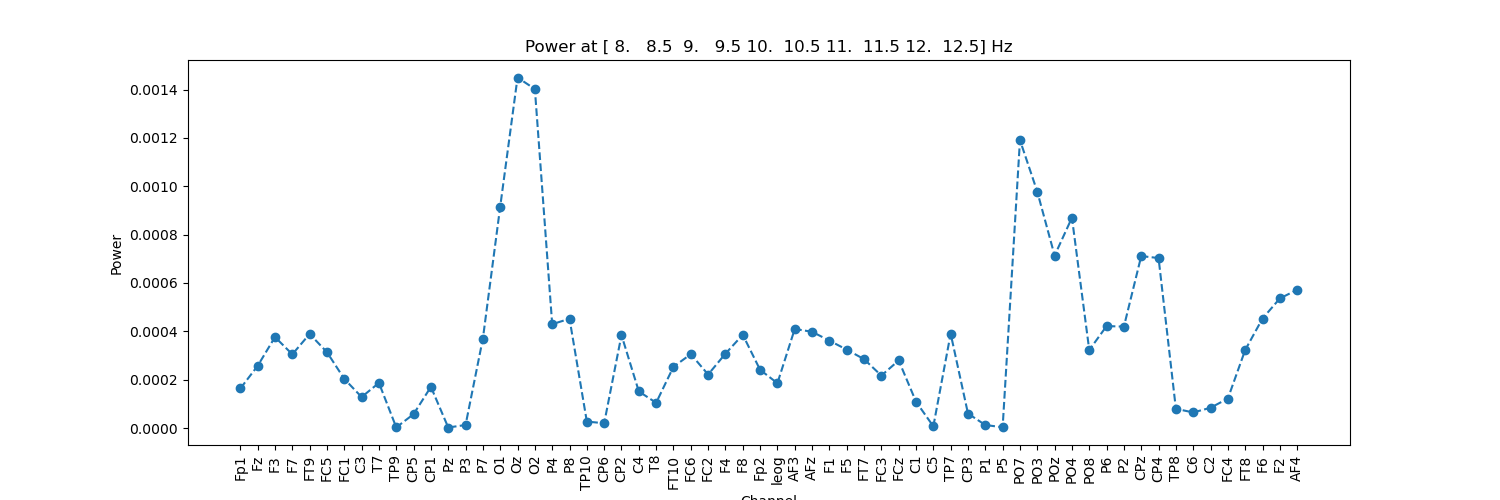

In [21]:
# Compute the 8-12Hz power at all channels using matrix multiplication
timeToPlot = 50 # Time in seconds to plot
t = raw.times[raw.times < timeToPlot]
N = len(t)
x = np.arange(0,N)/N
X = data[:, raw.times < timeToPlot]

SR = raw.info['sfreq']
freq_res = SR/len(X)
freqs = np.fft.fftfreq(N, 1/SR)
freqs = freqs[:N//2]
powerMat = np.zeros((n_channels, 1))
k_range = np.arange(8, 13, 0.5)

powerMat = np.zeros((n_channels, len(k_range)))
for i, k in enumerate(k_range):
    # Create a complex sine wave at frequency k
    W = np.exp(-1j * 2 * np.pi * k * N * x)
    # print(W.shape)
    # print(X.shape)

    # Compute the inner product (DFT coefficient for frequency k)
    # We use matrix multiplication!
    X_k = (W.T @ X.T).T

    powerMat[:, i] = np.real(X_k)**2 + np.imag(X_k)**2

powerVec = np.mean(powerMat, axis=1)

plt.figure(figsize=(15, 5))
plt.plot(raw.ch_names[:-4], powerVec[:-4], 'o--')
plt.xlabel('Channel')
plt.ylabel('Power')
plt.title(f'Power at {k_range} Hz')
plt.xticks(rotation=90)
plt.show()

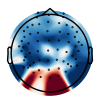

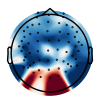

In [22]:
# We can visualize the power in specific frequency band as power in topoplot
# timeToPlot = 2000
# t = raw.times[raw.times < timeToPlot]
# X = data[:, raw.times < timeToPlot]

# psds, freqs = mne.time_frequency.psd_array_multitaper(X, sfreq=raw.info['sfreq'], fmin=freq_range[0], fmax=freq_range[1])
# alpha_power = psds.mean(axis=1)

# Exclude the non-EEG channels
picks = mne.pick_types(raw.info, eeg=True, exclude=['leog', 'reog', 'egg', 'audio'])

# Select alpha power for only EEG channels
# Drop 2nd dimension
alpha_power = powerVec.reshape(-1)
alpha_power_eeg = alpha_power[picks]
info_eeg = mne.pick_info(raw.info, picks)

# Plot the topomap for alpha power (only using the EEG channels)
mne.viz.plot_topomap(alpha_power_eeg, info_eeg, cmap='RdBu_r', contours=0)
plt.show()